<img src="nb_imgs/CV_ON22.png" style="border-radius:15px">

# <b><div style="color:#211894;font-size:100%;text-align:center">Welcome to the Computer Vision Track of the Hackathon! 👁</div></b>
# <b><div style="color:#211894;font-size:100%;text-align:center">[Checkout the Video Walkthrough!](https://bcove.video/3BK2hqS)</div></b>

# <a id="TOC">Table of Contents</a> 
- [1. Introduction](#1)  
    - [1.1 Learning Objectives ](#1_1)
    - [1.2 Import Libraries](#1_1)
    - [1.3 Introduction to VGG16 Model](#1_1)
    - [1.4 Hardware Component](#1_1)
    - [1.5 Software Component](#1_1)
- [2. Exploratory Data Analysis](#2)
- [3. Defining Custom VGG-16 Model](#3)  
- [4. Deep Learning with Stock PyTorch and Deploying with OpenVINO Inference Engine](#4)
- [5. INT8 OpenVINO Model Optimizer (Overview)](#4)
- [6. Summary and Learnings](#4)

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">1 | Introduction</div></a>

In this notebook, we'll introduce the <b>[Visual Quality Inspection AI Reference Kit](https://github.com/oneapi-src/visual-quality-inspection)</b> and show you how to use Intel-optimized libraries for machine learning so you can win the Hackathon! The reference kit GitHub page provides a link to various datasets that all revolve around the concept of visually inspecting damaged products in the manufacturing process. In the future, you could play around with toothbrush, tiles, wood, etc. but in this notebook we will focus on pill quality. In this dataset, consumer over the counter medicial supplements are classfified into good or bad categories. Bad pills are ones that contain chips, cracks, or mishapen features. 

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.1 | Learning Objectives</span></a></b>
Given this Visual Quality Inspection dataset, you'll build an end-to-end Machine Learning pipeline using Intel's oneAPI toolkits to optimize the training cycles, prediction throughput, and accuracy. The main component we'll be working with is <b>[Intel&reg; OpenVINO](https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/overview.html)</b>

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.2 | Import Libraries</span></a></b>


In [1]:
import os
import sys
import time
import argparse
import itertools
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import intel_extension_for_pytorch
import boto3

from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import models
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split, StratifiedKFold

# adding src to path 
module_path = os.path.abspath(os.path.join('./src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# utilities
from src.utils.dataloader import get_train_test_loaders, get_cv_train_test_loaders
from src.utils.helper import train, evaluate, predict_localize
from src.utils.dataloader import get_train_test_loaders

import logging as log
import cv2
from openvino.inference_engine import IECore

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.3 | Introduction to VGG16 Model</span></a></b>


VGG-16 is a convolutional neural network that is 16 layers deep and same has been used as classification architecture to classify the good and defect samples from the production pipeline. Intel® Extension for PyTorch* is used for transfer learning the VGGNet classification architecture on the pill dataset created. Same experiment performed in stock PyTorch version of VGGNet.

VGG-16 was one of the best performing architectures in the ILSVRC challenge 2014.It was the runner up in the classification task with a top-5 classification error of 7.32% (only behind GoogLeNet with a classification error of 6.66%). It was also the winner of localization task with 25.32% localization error.

Limitations Of VGG 16:

- It is very slow to train (the original VGG model was trained on Nvidia Titan GPU for 2-3 weeks).
- The size of VGG-16 trained imageNet weights is 528 MB. So, it takes quite a lot of disk space and bandwidth which makes it inefficient.
- 138 million parameters lead to exploding gradients problem.

**Some Helpful Resources**: 
- Link to VGG16 paper: https://arxiv.org/abs/1409.1556
- Link to GeekforGeeks Article: https://www.geeksforgeeks.org/vgg-16-cnn-model/

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.4 | Hardware Component</span></a></b>

In this track of the Hackathon, we will be using a 3rd Generation Intel&reg; Xeon&reg; Platinum 8375C processor, which is an Ice Lake CPU, on an AWS M6i.4xlarge instance. The details of the hardware are shown below.

In [2]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Platinum 8375C CPU @ 2.90GHz
    CPU family:          6
    Model:               106
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            6
    BogoMIPS:            5799.91
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid aperfmperf tsc_known_freq pni pc
                         lmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe 
                         popcnt tsc_deadline_timer aes xsave 

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.5 | Software Component</span></a></b>

OpenVINO toolkit is a free toolkit facilitating the optimization of a deep learning model from a framework and deployment using an inference engine onto Intel hardware.

#### The Intel® Distribution of OpenVINO™ toolkit includes:

- A model optimizer to convert models from popular frameworks such as Caffe*, TensorFlow*, Open Neural Network Exchange (ONNX*), and Kaldi
- Neural Network Compression Framework (NNCF) and Post-training Optimization Toolkit (POT) for model optimization during and after training, respectively. 
- An inference engine that supports heterogeneous execution across computer vision accelerators from Intel, including CPUs, GPUs, FPGAs, and the Intel® Neural Compute Stick 2 (Intel® NCS2)
- Common API for heterogeneous Intel® hardware

<img src="nb_imgs/openvino_workflow.png" style="border-radius:15px">

#### Benchmarks performed in Visual Quality Inspection Reference Kits 

<img src="nb_imgs/vino_stats.PNG" style="border-radius:15px">

#### Key Takeaways

- Realtime prediction time speedup with OpenVINO FP32 Pill anomaly detection model shows up to 2.74x against Stock Pytorch 1.8.0 FP32 model
- Realtime prediction time speedup with OpenVINO INT8 quantized Pill anomaly detection model shows up to 13.16x against Stock Pytorch 1.8.0 FP32 model
- Batch prediction time speedup with OpenVINO FP32 Pill anomaly detection model shows from 1.11x to 1.59x against Stock Pytorch 1.8.0 FP32 model
- Batch prediction time speedup with OpenVINO INT8 quantized Pill anomaly detection model shows from 5x to 6.9x against Stock Pytorch 1.8.0 FP32 model

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">2 | Exploratory Data Analysis</div></a>

#### Quality control in the pharmaceutical industry is a very critical component. Let’s look at the different aspects of acceptable and defective pills. 

Some of the defects that we can expect: 
- color 
- contamination 
- crack
- fault imprint
- wrong pill type
- scratches

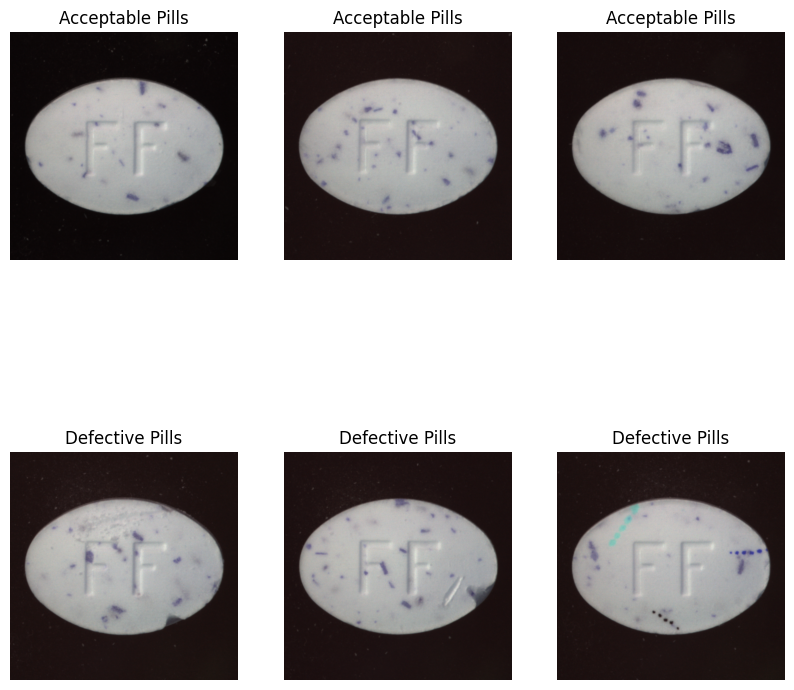

Number of Acceptable Samples 210
Number of Defective Samples 357


In [3]:
import cv2

train_dir = './data/train' # image folder

# get the list of jpegs from sub image class folders
good_imgs = [fn for fn in os.listdir(f'{train_dir}/good') if fn.endswith('.png')]
bad_imgs = [fn for fn in os.listdir(f'{train_dir}/bad') if fn.endswith('.png')]

# randomly select 3 of each
select_norm = np.random.choice(good_imgs, 3, replace = False)
select_pneu = np.random.choice(bad_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (10,10))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/good/{select_norm[i]}'
        label = 'Acceptable Pills'
    else:
        fp = f'{train_dir}/bad/{select_pneu[i-3]}'
        label = 'Defective Pills'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = cv2.imread(fp)
    fn_gray = cv2.cvtColor(fn, cv2.COLOR_BGR2GRAY)
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
print(f'Number of Acceptable Samples {len(good_imgs)}')
print(f'Number of Defective Samples {len(bad_imgs)}')

#### Convert images to numpy arrays for deeper analysis

In [4]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = cv2.imread(fp)
        current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        
        # covert image to a matrix
   #    img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [current_image.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
good_images = img2np(f'{train_dir}/good/', good_imgs)
bad_images = img2np(f'{train_dir}/bad/', bad_imgs)

#### Statistical-Visual analysis of "Acceptable" and "Defective" Pills

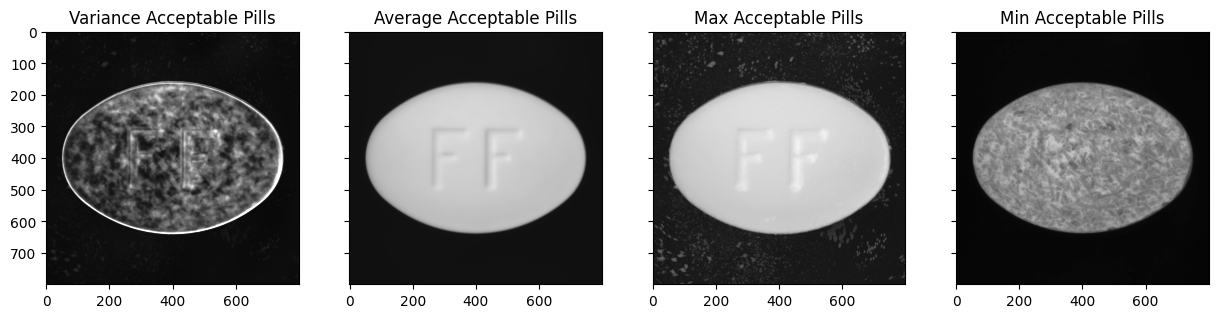

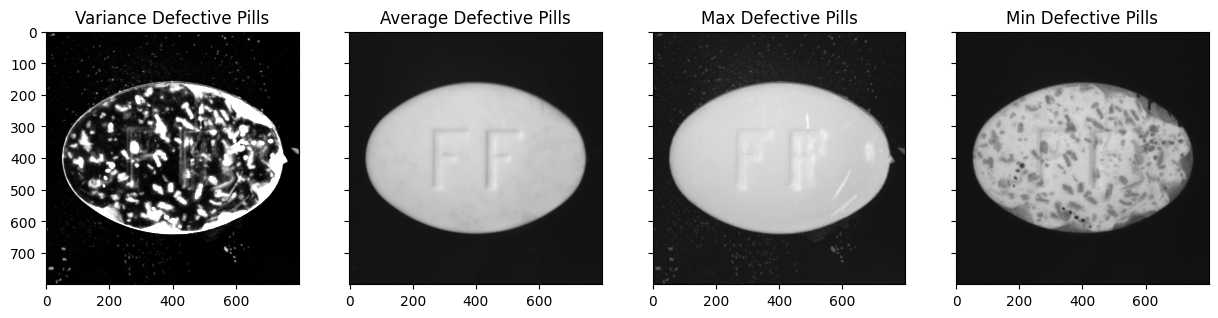

In [5]:
def find_stat_img(full_mat, title, size = (800, 800)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    var_img = np.var(full_mat, axis = 0)
    var_img = var_img.reshape(size)
    max_img = np.amax(full_mat, axis = 0)
    max_img = max_img.reshape(size)
    min_img = np.amin(full_mat, axis = 0)
    min_img = min_img.reshape(size)
    
    figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(15, 15))
    ax1.imshow(var_img, vmin=0, vmax=255, cmap='Greys_r')
    ax1.set_title(f'Variance {title}')
    ax2.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    ax2.set_title(f'Average {title}')
    ax3.imshow(max_img, vmin=0, vmax=255, cmap='Greys_r')
    ax3.set_title(f'Max {title}')
    ax4.imshow(min_img, vmin=0, vmax=255, cmap='Greys_r')
    ax4.set_title(f'Min {title}')
    plt.show()
    return mean_img, var_img, max_img, min_img

good_mean, good_var, good_max, good_img = find_stat_img(good_images, 'Acceptable Pills')
bad_mean, bad_var, bad_max, bad_img = find_stat_img(bad_images, 'Defective Pills')

#### The difference between the average "Acceptable" and "Defective" pills indicates the ares most often aflicted by defects.

We see from this analysis that the main difference between Acceptable and Defective pills is a small defect in the upper right of the pills and what appears to be discoloration on the right side of the pill. This could indicate an issue with the manufacturing process that damages the right side of some pills. 

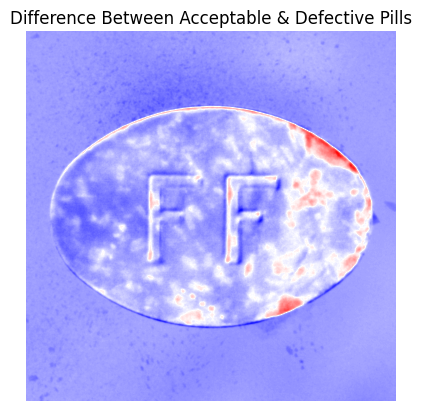

In [6]:
contrast_mean = good_mean - bad_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Acceptable & Defective Pills')
plt.axis('off')
plt.show()

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">3 | VGG-16 Model Definition</div></a>

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.1 | VGG-16 Model</span></a></b>

Custom multi-class classification model with VGG16 feature extractor, pretrained on ImageNet and custom classification head. Parameters for the first convolutional blocks are frozen to allow for transfer learning.

##### What does this function return?
- Returns class scores when in train mode.
- Returns class probs and normalized feature maps when in eval mode.

In [7]:
class CustomVGG(nn.Module):

    def __init__(self, n_classes=2):
        super().__init__()
        self.feature_extractor = models.vgg16(pretrained=True).features[:-1]
        self.classification_head = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(
                kernel_size=(INPUT_IMG_SIZE[0] // 2 ** 5, INPUT_IMG_SIZE[1] // 2 ** 5)
            ),
            nn.Flatten(),
            nn.Linear(
                in_features=self.feature_extractor[-2].out_channels,
                out_features=n_classes,
            ),
        )
        # self._freeze_params()

    def _freeze_params(self):
        for param in self.feature_extractor[:23].parameters():
            param.requires_grad = False

    def forward(self, x_in):
        """
        forward
        """
        feature_maps = self.feature_extractor(x_in)
        scores = self.classification_head(feature_maps)

        if self.training:
            return scores

        probs = nn.functional.softmax(scores, dim=-1)

        weights = self.classification_head[3].weight
        weights = (
            weights.unsqueeze(-1)
            .unsqueeze(-1)
            .unsqueeze(0)
            .repeat(
                (
                    x_in.size(0),
                    1,
                    1,
                    INPUT_IMG_SIZE[0] // 2 ** 4,
                    INPUT_IMG_SIZE[0] // 2 ** 4,
                )
            )
        )
        feature_maps = feature_maps.unsqueeze(1).repeat((1, probs.size(1), 1, 1, 1))
        location = torch.mul(weights, feature_maps).sum(axis=2)
        location = F.interpolate(location, size=INPUT_IMG_SIZE, mode="bilinear")

        maxs, _ = location.max(dim=-1, keepdim=True)
        maxs, _ = maxs.max(dim=-2, keepdim=True)
        mins, _ = location.min(dim=-1, keepdim=True)
        mins, _ = mins.min(dim=-2, keepdim=True)
        norm_location = (location - mins) / (maxs - mins)

        return probs, norm_location

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.2 | Variables, Constants, and Hyperparameters</span></a></b>

In [8]:
# Setting Constants
GOOD_CLASS_FOLDER = "good"
DATASET_SETS = ["train", "test"]
IMG_FORMAT = ".png"
INPUT_IMG_SIZE = (224, 224)
NEG_CLASS = 1
DATA_AUG = 1

# Setting Variables
data_folder = './data/'
subset_name = './models/VGG16_stock'

# Parameters used for the training DL model and hyperparameter Tuning
BATCH_SIZE = 10
TARGET_TRAINING_ACCURACY = 1.0
LR = 0.0001
EPOCHS = 3
class_weight = [1, 3] if NEG_CLASS == 1 else [3, 1]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HEATMAP_THRESH = 0.7

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">4 | Deep Learning with Stock and Deploying with OpenVINO Inference Engine</div></a>

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">4.1 | PyTorch and ONNX Models</span></a></b>

In [9]:
# Create data loaders
train_loader, test_loader = get_train_test_loaders(
    root=data_folder, batch_size=BATCH_SIZE, test_size=0.2, random_state=42)

Dataset ./data/: N Images = 637, Share of anomalies = 0.568


In [10]:
# Model Training
# Intitalization of DL architecture along with optimizer and loss function
model = CustomVGG()
class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training module
start_time = time.time()
trained_model = train(
    train_loader, model, optimizer, criterion, EPOCHS,
    DEVICE, TARGET_TRAINING_ACCURACY,data_aug=DATA_AUG)
train_time = time.time()-start_time

print('train_time=', train_time)

# Saving HDF5 PyTorch Model
model_path = f"{subset_name}_model.h5"
torch.save(trained_model, model_path)

# Saving ONNX Model
dummy_input = Variable(torch.randn(1, 3, 224, 224))
torch.onnx.export(trained_model, dummy_input, f"{subset_name}_model.onnx")

/home/ubuntu/miniconda3/envs/cv_hackathon_openvino/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/cv_hackathon_openvino/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Applying DataAugmentation----> Flipping/Rotation/Enhancing/Cropping and keeping the Regular images as well
Epoch 1/3: Loss = 0.2575, Accuracy = 0.7804
Epoch 2/3: Loss = 0.0163, Accuracy = 0.9948
Epoch 3/3: Loss = 0.0033, Accuracy = 0.9984
train_time= 1140.546196937561


##### Let's evaluate the architecture of our trained model and see the total trained parameters

In [11]:
from torchsummary import summary

summary(trained_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

##### Make a prediction on the test dataset

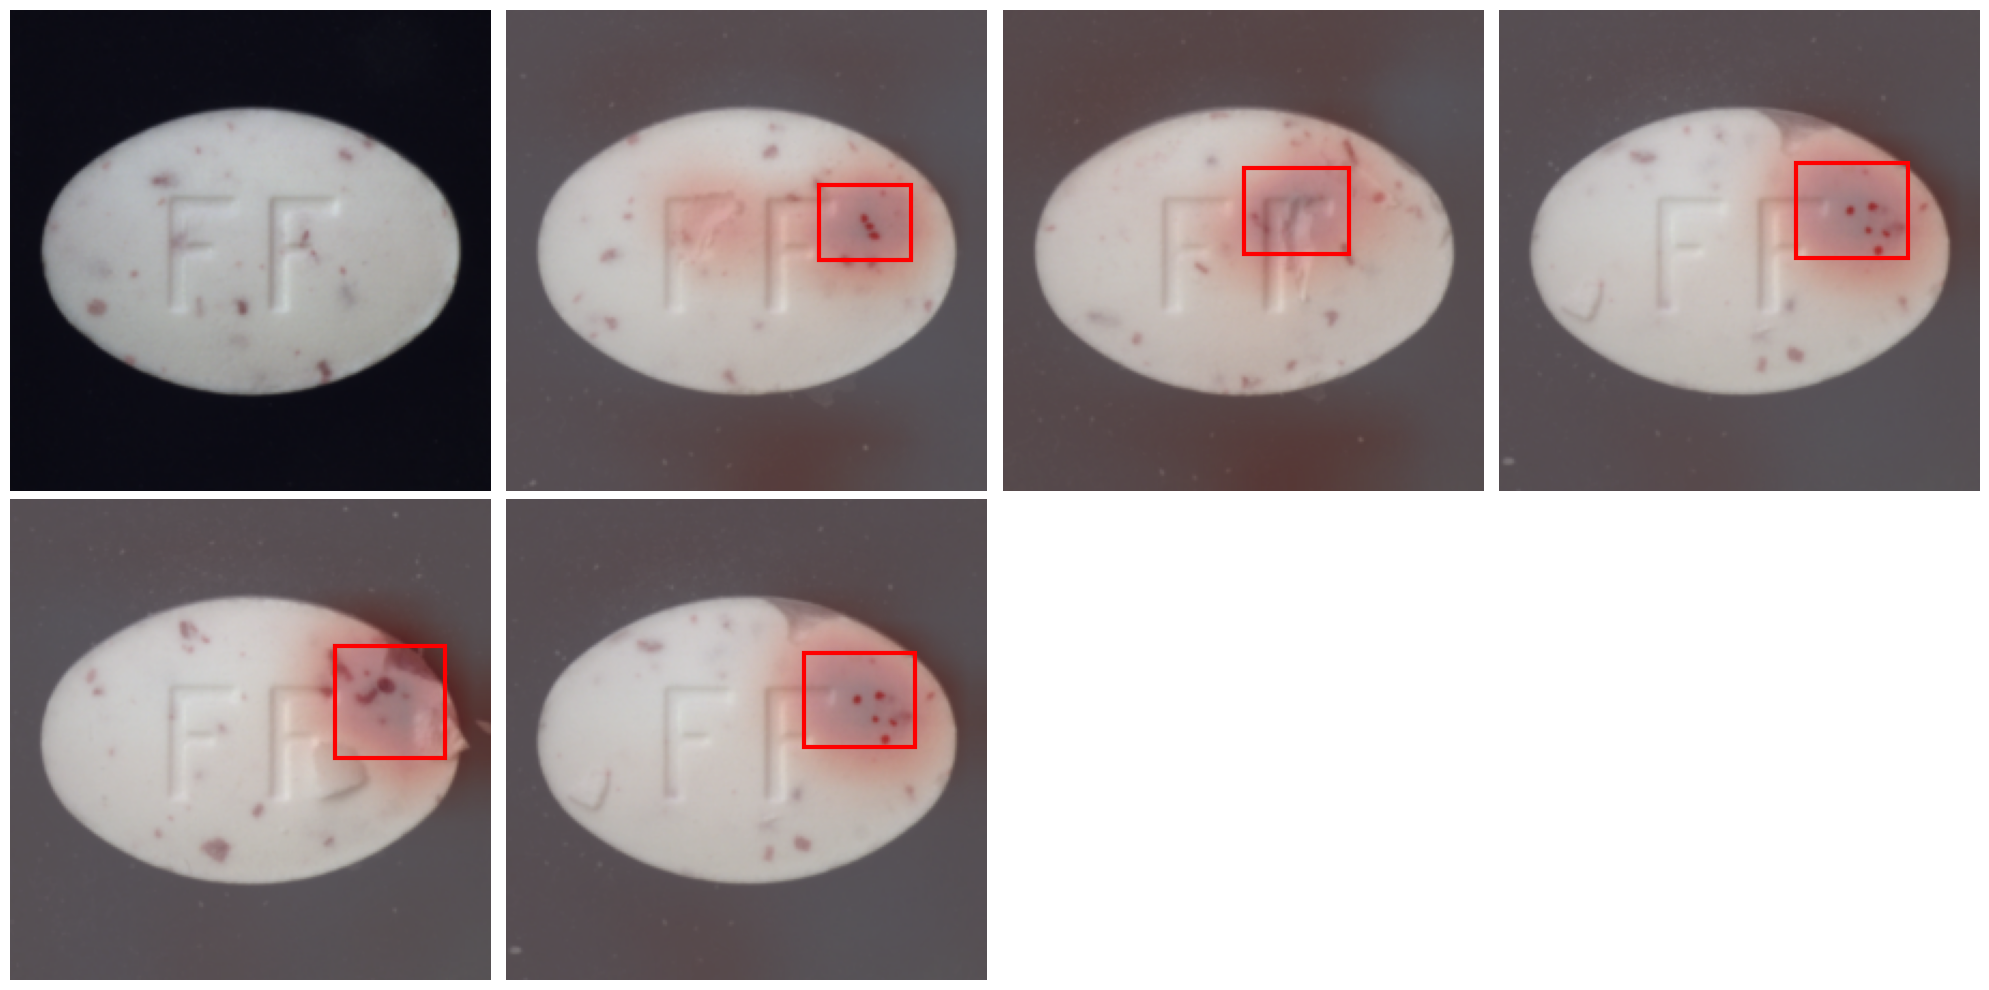

In [12]:
predict_localize(trained_model, test_loader, DEVICE, thres=HEATMAP_THRESH, n_samples=6, show_heatmap=True)

Sample Evaluation and Confusion Matrix

infer_time_per_sample= 0.40197277069091797
infer_time_per_sample= 0.42160701751708984
infer_time_per_sample= 0.4034092426300049
infer_time_per_sample= 0.4191901683807373
infer_time_per_sample= 0.3831756114959717
infer_time_per_sample= 0.3660562038421631
infer_time_per_sample= 0.3832204341888428
infer_time_per_sample= 0.34658026695251465
infer_time_per_sample= 0.3752553462982178
infer_time_per_sample= 0.35775136947631836
infer_time_per_sample= 0.3802945613861084
infer_time_per_sample= 0.38698816299438477
infer_time_per_sample= 0.306398868560791
Accuracy:  1.0
Balanced Accuracy:  1.0


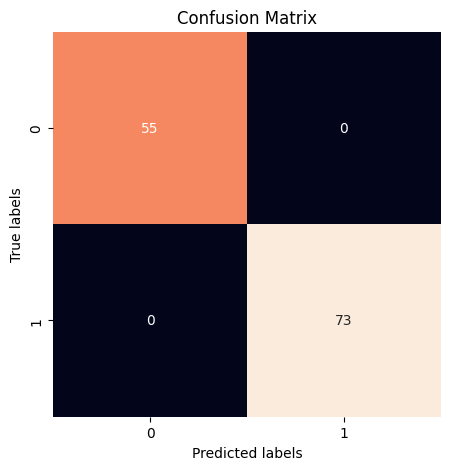

In [13]:
evaluate(trained_model, test_loader, DEVICE)

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">4.2 | Initialize Inference Engine Core</span></a></b>

In [14]:
# Creating Inference Engine
inference_engine = IECore()
device= 'CPU'

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">4.3 | Read ONNX Model</span></a></b>

In [15]:
onnx_model_path= './models/VGG16_stock_model.onnx'

# Read a model in OpenVINO Intermediate Representation or ONNX format
print("Reading the network:", onnx_model_path)
# (.xml and .bin files) or (.onnx file)
net = inference_engine.read_network(model=onnx_model_path)

Reading the network: ./models/VGG16_stock_model.onnx


## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">4.4 | Configure Input and Output Blobs</span></a></b>

In [23]:
image_path = './data/test/bad/'
out_blob = '65'

# Configuring input and output blobs 
# Get names of input and output blobs
input_blob = next(iter(net.input_info))

# Set input and output precision manually
net.input_info[input_blob].precision = 'FP32'
net.outputs[out_blob].precision = 'FP32'

# Get a number of input images
apath = os.path.abspath(image_path)
files = os.listdir(apath)
num_of_input = len(files)
net.batch_size = num_of_input

# Get a number of classes recognized by a model
num_of_classes = net.outputs[out_blob].shape[1]
print(f'We have {num_of_input} images to test OpenVINO Inference Engine with!')

We have 5 images to test OpenVINO Inference Engine with!


#### Let's analyze the input and output layers to make sure we have loaded the model properly

In [24]:
# check input layers
print(f"input layout: {net.input_info['input.1'].layout}")
print(f"input precision: {net.input_info['input.1'].precision}")
print(f"input shape: {net.input_info['input.1'].tensor_desc.dims}")

input layout: NCHW
input precision: FP32
input shape: [5, 3, 224, 224]


In [25]:
# check output layers
print(f"output layout: {net.outputs['65'].layout}")
print(f"output precision: {net.outputs['65'].precision}")
print(f"output shape: {net.outputs['65'].shape}")

output layout: NC
output precision: FP32
output shape: [5, 2]


## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">4.5 | Loading Model to the Device</span></a></b>

In [26]:
# Loading the model to the plugin 
exec_net = inference_engine.load_network(network=net, device_name=device)

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">4.6 | Inference Engine</span></a></b>

In [27]:
top_results = 2

# Step 5. Create infer request
# load_network() method of the IECore class with a
# specified number of requests (default 1) returns an ExecutableNetwork
# instance which stores infer requests. So you already created
# Infer requests in the previous step.

# Step 6. Prepare input
# input_data = []
n_batch, channels, height, width = net.input_info[input_blob].input_data.shape
input_data = np.ndarray(shape=(n_batch, channels, height, width))

for i in range(num_of_input):
    image = cv2.imread(apath + '/' + files[i])

    if image.shape[:-1] != (height, width):
        image = cv2.resize(image, (width, height))

    # Change data layout from HWC to CHW
    image = image.transpose((2, 0, 1))
    # Add N dimension to transform to NCHW
    image = np.expand_dims(image, axis=0).astype(np.float32)

    input_data[i] = image

# Step 7. Process output
starttime = time.time()
res = exec_net.infer(inputs={input_blob: input_data})
itime = time.time() - starttime

# Processing output blob
print("Processing output blob")
res = res[out_blob]
print("Top ", top_results, " results: ")

#else:
labels_map = None

classid_str = "classid"
probability_str = "probability"

for i, probs in enumerate(res):
    probs = np.squeeze(probs)
    top_ind = np.argsort(probs)[-top_results:][::-1]
    fname = apath + '/' + files[i]
    print("Image {}", fname)
    print(classid_str, probability_str)
    print('-' * len(classid_str), '-' * len(probability_str))
    for idx in top_ind:
        det_label = labels_map[idx] if labels_map else str(idx)
        label_length = len(det_label)
        space_num_before = (len(classid_str) - label_length) // 2
        space_num_after = len(classid_str) - (space_num_before + label_length) + 2
        space_num_before_prob = (len(probability_str) - len(str(probs[idx]))) // 2
        print(' ' * space_num_before, det_label,
                  ' ' * space_num_after, ' ' * space_num_before_prob, probs[idx])

print(f"Inference time for the batch of {str(num_of_input)} images {str(itime)} secs.")

Processing output blob
Top  2  results: 
Image {} /home/ubuntu/cv-hackathon/data/test/bad/015.png
classid probability
------- -----------
    1            1.0
    0        1.302468e-12
Image {} /home/ubuntu/cv-hackathon/data/test/bad/016.png
classid probability
------- -----------
    0            1.0
    1        3.1685722e-25
Image {} /home/ubuntu/cv-hackathon/data/test/bad/012.png
classid probability
------- -----------
    0            1.0
    1            0.0
Image {} /home/ubuntu/cv-hackathon/data/test/bad/014.png
classid probability
------- -----------
    0            1.0
    1        1.3161516e-37
Image {} /home/ubuntu/cv-hackathon/data/test/bad/013.png
classid probability
------- -----------
    0            1.0
    1        1.6986517e-15
Inference time for the batch of 5 images 0.7315473556518555 secs.


# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">5 | OpenVINO Model Optimizer (Overview) </div></a>

The OpenVINO model optimizer is considered a CLI tool and thus is out of scope for this python notebook. Nonetheless, we wanted to share some general highlights and methodologies explored in the original AI Reference Kit example. This could be an excellent way to boost your model's performance. 

Here is a list of the different model optimization tools that OpenVINO offers, please feel free to explore these using the free toolkit: 
- **Model Optimizer (MO)** is a cross-platform command-line tool that facilitates the transition between training and deployment environments, performs static model analysis, and adjusts deep learning models for optimal execution on end-point target devices. 
- **Neural Network Compression Framework (NNCF)** provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO™ with minimal accuracy drop. It is designed to work with models from PyTorch and TensorFlow. The framework is organized as a Python* package that can be built and used in a standalone mode. 
- **Post-training Optimization Toolkit**  is designed to accelerate the inference of deep learning models by applying special methods without model retraining or fine-tuning, like post-training quantization. Therefore, the tool does not require a training dataset or a pipeline. 

For the hackathon we will only allow submissions using the OpenVINO Model Optimizer (MO). This requires that you submit your model in OpenVINO Intermediate Representation (IR) Format. There will be mentors available to help you achieve this if you need help. Here are a couple links that may help you get started: 
- Notebook example of MO: https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/205-vision-background-removal
- MO Docs https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html

#### Performance Benchmarking of full precision (FP32) Model
Use the below command to run the benchmark tool for the ONNX model generated using this codebase for the pill anamoly detection.

*source /opt/intel/openvino_2021/bin/setupvars.sh*

*python3 /opt/intel/openvino_2021/deployment_tools/tools/benchmark_tool/benchmark_app.py -m pill_intel_model.onnx*

#### Model Quantization
##### Configurations
Below are the configurations which needs to be modified prior to run this postraining optimization tool.

- env/openvino_pot/pill_intel_model_int8.json DefaultQuantization Configuration - Update model, weights and config according to the appropriate file location
- env/openvino_pot/pill_intel_model_int8_acc.json AccuracyAwareQuantization Configuration - Update model, weights and config according to the appropriate file location
- env/openvino_pot/pill_intel_model.yml Dataconverter Configuration - Update 'data_source' and 'data_dir' to the dataset folder location

#### Model Quantization
*source /opt/intel/openvino_2021/bin/setupvars.sh*

*pot -c env/openvino_pot/pill_intel_model_int8.json -e*

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">6 | Summary and Learnings</div></a>

With just a few additions to our code, we have been able to optimize a custom VGG16 binary classification model on intel hardware. Our ability to transfer learn efficiently has allowed us to take a pre-trained torch VGG16 model and transfer learn (tune) with images from our pill dataset and turn it into an efficient classification tool for pharmaceutical quality control.

We also learned how to perform inference with OpenVINO's Inference Engine. In a scenario where we had various XPUs available, we could have explored a distributed heterogeous inference workflow. This may be the subject of an expanded version of this case study.

## <span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">Notices & Disclaimers</span>
Intel optimizations, for Intel compilers or other products, may not optimize to the same degree for non-Intel products.  
Performance varies by use, configuration and other factors. Learn more on the Performance Index site.   
Performance results are based on testing as of dates shown in configurations and may not reflect all publicly available updates.  See backup for configuration details.  No product or component can be absolutely secure.   
Your costs and results may vary.   
Intel technologies may require enabled hardware, software or service activation.  
&copy; Intel Corporation.  Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries.  Other names and brands may be claimed as the property of others.  